## Reddit Scraping
Documentation reference: https://praw.readthedocs.io/en/stable/

In [51]:
import requests
import pandas as pd
import praw
from praw.models import MoreComments

import os
import zipfile
import ast
import re
# Tools for text analysis
# We can use nltk to extract adjective and verbs related to the product/brand 
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# Vader sentiment analysis 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

os.makedirs("../output", exist_ok=True)
from dotenv import load_dotenv
load_dotenv()


True

# Scrape post from related subreddits
Focus: get the raw related data from various subreddits

In [43]:

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT"),
    username=os.getenv("REDDIT_USERNAME"),
)

# "Skincare_Addiction", "asianskincare", "Blackskincare","SkincareAddicts"
subreddit_list = ["SkincareAddiction", "Sephora"]

all_posts = []

# get the top 20 post from each subreddit (don't know rate limit so 20 for now)
# Documentation: https://praw.readthedocs.io/en/stable/code_overview/models/subreddit.html

# add some more variation to the search query 
target_brands = [
'Estée Lauder',
'Fenty Beauty',
'Fenty',
'e.l.f. Cosmetics',
'e.l.f.',
'Tarte Cosmetics',
'Tarte',
'Glossier',
'Laneige',
'Sulwhasoo',
'Etude House',
'Etude',
'Innisfree',
'COSRX',
]

def is_bot(author):
    if author is None:
        return True
    name = author.name.lower()
    return "bot" in name or name == "automoderator"

# Match by header title (should I go more in depth here?)
def brand_word_match(text, brand_list):
    match = process.extractOne(text, brand_list, scorer=fuzz.partial_ratio)
    if match and match[1] > 85:
        return match[0]
    return None


def get_top_comments(post):

    post.comments.replace_more(limit=0)  

    top_comments = []
    for comment in post.comments:
        if isinstance(comment, MoreComments):
            continue 
        if is_bot(comment.author):
            continue
        if comment.body.strip().lower() in ["[deleted]", "[removed]"]:
            continue 
        top_comments.append(comment.body.strip())
        if len(top_comments) == 10:
            break
    return top_comments


reddit_tags = ['[Product Question]', '[Review]']
# Filter out duplicate posts 
post_seen = {}
for sub in subreddit_list:
    try:
        for brand in target_brands:
            for tag in reddit_tags:
                query = f'"{tag} {brand}"'
                post_collection = reddit.subreddit(sub).search(query.lower(), limit=20, sort="relevance")
                for post in post_collection: 
                    is_match = brand_word_match(post.title, target_brands)
                    if is_match:
                        top_comments = get_top_comments(post)
                        all_posts.append({
                        "subreddit_name": sub,
                        "post_id": post.id,
                        "title": post.title,
                        "description": post.selftext,
                        "score": post.score,
                        "num_comments": post.num_comments,
                        "top_comments": top_comments,
                        "upvote_ratio": post.upvote_ratio,
                        "brand": brand
                    })
    except Exception as e:
        print(f"Error scraping {sub}: {e}")
        continue
    
subreddit_df = pd.DataFrame(all_posts)

# subreddit_df.to_csv("../output/subreddit_data.csv", index=False)



In [44]:
subreddit_df[subreddit_df['brand'] == 'Fenty']

,subreddit_name,post_id,title,description,score,num_comments,top_comments,upvote_ratio,brand
7,SkincareAddiction,1jyo7jn,[Product Question] Fenty Skin Pre-Show Glow Re...,Ok so I just got this product and is it just m...,2,1,[],1.00,Fenty
8,SkincareAddiction,1gwhfhy,[Product Question] Fenty foundation causing co...,"Hey gurus, I've been using Fenty Pro Filt'r fo...",2,4,[Are you double cleansing to remove all your m...,1.00,Fenty
9,SkincareAddiction,1folpw1,[Product Question] Fenty Beauty Jumbo Butta Dr...,I’m a male (28) for context. Interested in the...,1,1,[],1.00,Fenty
10,SkincareAddiction,19dznbs,[Product Question] Fenty Pre-Show Glow - am I ...,I've been using Pixi Glow Tonic 2 times per w...,2,4,[It should be fine if your skin tolerates it b...,1.00,Fenty
11,SkincareAddiction,13pvlva,[Product Question] Fenty Cleansr,,0,1,[],0.50,Fenty
12,SkincareAddiction,zg5k4b,[Product Question] Fenty Watch Ya Tone,Hello! \n\nI'm just a little confused about th...,7,3,[Personally I like this serum. I was coming of...,0.90,Fenty
13,SkincareAddiction,jby4vm,[Product Question] Fenty Fat Water Toner Serum,"Lately, I’ve been using CosRx Centella Water A...",4,10,"[Update: I wanted to love her sooooo badly, bu...",0.83,Fenty
14,SkincareAddiction,7pn3lm,[product question] Fenty foundation ingredients?,I’m always looking for foundations that my ski...,3,3,"[if you are allergic to the fruits listed, I w...",0.81,Fenty
15,SkincareAddiction,i0l1w2,[Review] Lab Muffin reviews Fenty Skin launch,,27,19,[It seems to me like most influencers are walk...,0.88,Fenty
16,SkincareAddiction,i4jg59,[Review] Fenty Skin,So I’m a guy and i was looking for skincare al...,19,9,[The toner and the sunscreen tingling ...that ...,0.74,Fenty


# Comment text cleaning 

Before: Comment is under a list 

After: Each comment within the list is broken down into a row

In [45]:
rows = []
for _, row in subreddit_df.iterrows():
    for comment in row["top_comments"]:
        rows.append({
            "post_id": row["post_id"],
            "title": row["title"],
            "brand": row["brand"],
            "subreddit_name": row["subreddit_name"],
            "comment": comment
        })
        
comments_df = pd.DataFrame(rows)
comments_df.head()


,post_id,title,brand,subreddit_name,comment
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and..."
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...


In [46]:
custom_stopwords = []
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)

def preprocess_comment(comment):
    # lower case 
    comment= comment.lower()
    # remove url 
    comment = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", comment)
    # remove non-alphabetic characters 
    comment = re.sub(r"[^a-z\s]", " ", comment)

    tokens = word_tokenize(comment)
    # remove stopwords 
    filtered_tokens = [t for t in tokens if t.isalpha() and t not in stopword_set]
    return " ".join(filtered_tokens)

comments_df["cleaned_comment"] = comments_df["comment"].apply(preprocess_comment)

comments_df.to_csv("../output/subreddit_comment_data.csv", index=False)
comments_df.head()

,post_id,title,brand,subreddit_name,comment,cleaned_comment
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...


In [48]:

comment_rows = []

# Search for mentioning of brand value ?
# tagging brand to the comment and getting the sentiment score



for _, row in comments_df.iterrows():
    search_brand = row["brand"].lower().strip()
    comment = row["cleaned_comment"]
    
    comment= comment.lower()

    sentiment_score = analyzer.polarity_scores(comment)["compound"]
    sentiment_label = (
        "positive" if sentiment_score > 0.05
        else "negative" if sentiment_score < -0.05
        else "neutral"
    )
    comment_rows.append({
        "post_id": row["post_id"],
        "title": row["title"],
        "comment": comment,
        "search_term": row["brand"],
        "subreddit": row["subreddit_name"],
        "sentiment_score": sentiment_score,
        "sentiment_label": sentiment_label
    })

comment_df = pd.DataFrame(comment_rows)
print(comment_df.sentiment_label.value_counts())
comment_df.head()

comment_df.to_csv("../output/subreddit_sentiment_data.csv", index=False)

sentiment_label
positive    383
negative     53
neutral      52
Name: count, dtype: int64


   normalized_brand  sentiment_score
0             COSRX         0.363119
1      Estée Lauder         0.559910
2       Etude House         0.648403
3      Fenty Beauty         0.250177
4          Glossier         0.607762
5         Innisfree         0.393596
6           Laneige         0.510677
7         Sulwhasoo         0.702080
8   Tarte Cosmetics         0.389537
9  e.l.f. Cosmetics         0.498753


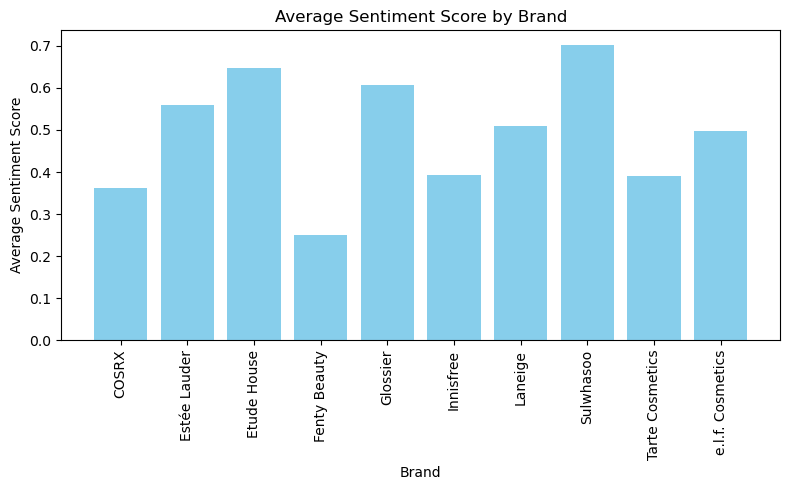

In [52]:
# These following brands are grouped together because they are the same company 
# Fenty and Fenty Beauty together 
# e.l.f. and e.l.f. Cosmetics together 
# Etude and Etude House together 
# Tarte and Tarte Cosmetics together 
brand_mapping = {
    'fenty': 'Fenty Beauty',
    'e.l.f.': 'e.l.f. Cosmetics',
    'etude': 'Etude House',
    'tarte': 'Tarte Cosmetics'
}

comment_df["normalized_brand"] = (
    comment_df["search_term"].str.lower().str.strip().map(brand_mapping)
    .fillna(comment_df["search_term"])
)

avg_sentiment = comment_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()

print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Brand")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()